In [1]:
import json
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1

# Face feature extractor

In [2]:
def clahe_hsv(img, clipLimit=2.0, tileGridSize=(5, 5)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cl = clahe.apply(v)

    hsv_clahe = cv2.merge((h, s, cl))

    final = cv2.cvtColor(hsv_clahe, cv2.COLOR_HSV2BGR)
    return final




In [3]:

def image_preprocessing(img, clipLimit=2, tileGridSize=(8, 8)):
    img = cv2.resize(img, (160, 160))
    clahe = clahe_hsv(img, clipLimit, tileGridSize)

    # Bilateral filter با قدرت کمتر تا جزئیات بمونه
    blur = cv2.bilateralFilter(clahe, 7, 60, 60)

    # Sharpening همون قبلی ولی کمی ضعیف‌تر
    kernel = np.array([[0, -1, 0],
                       [-1, 4.8, -1],
                       [0, -1, 0]])

    final = cv2.filter2D(blur, -1, kernel)
    final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
    return final

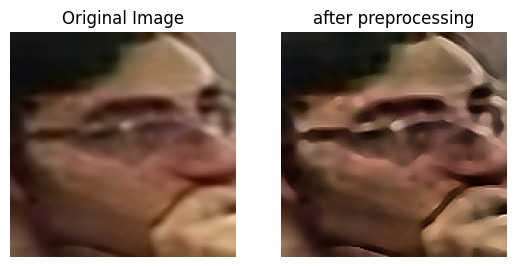

In [4]:

img = cv2.imread("processed_faces/face_1958.jpg")
result = image_preprocessing(img, clipLimit=2, tileGridSize=(8, 8))
img = cv2.resize(img, (160, 160))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title('after preprocessing')
plt.axis('off')

plt.show()

In [5]:
def extract_embeddings(face_metadata):
    print("Extracting embeddings...")

    model = InceptionResnetV1(pretrained='vggface2').eval()
    embeddings = []
    valid_metadata = []

    for data in tqdm(face_metadata, desc="Extracting embeddings"):
        data['filename'] = data['filename'].replace("temp_faces", "processed_faces")
        try:
            if data['confidence'] < 0.7:
                continue
            face_img = cv2.imread(data['filename'])
            if face_img is None:
                continue

            face_img = image_preprocessing(face_img)
            face_img = face_img.astype(np.float32) / 255.0
            face_img = np.transpose(face_img, (2, 0, 1))
            face_img = torch.tensor(face_img).unsqueeze(0)

            with torch.no_grad():
                embedding = model(face_img)

            embeddings.append(embedding.numpy().flatten())
            valid_metadata.append(data)
        except Exception as e:
            print(f"Error while extracting embeddings: {e}")

    return np.array(embeddings), valid_metadata

In [6]:
face_metadata = json.load(open("face_metadata.json", "r",encoding="utf-8"))
face_embeddings, face_metadata = extract_embeddings(face_metadata)


Extracting embeddings...


Extracting embeddings: 100%|██████████| 6018/6018 [04:08<00:00, 24.25it/s]


# clutser face feature

In [17]:
# import os
# import shutil
# from sklearn.cluster import HDBSCAN
# from sklearn.metrics.pairwise import cosine_similarity
#
# GROUPED_FACES_DIR = 'grouped_faces'
# REFINEMENT_THRESHOLD = 0.9
#
#
# def cluster_and_refine_faces(embeddings, valid_metadata):
#     # --- مرحله ۱: خوشه‌بندی اولیه ---
#     clusterer = HDBSCAN(
#         min_cluster_size=10,            # حداقل تعداد اعضا برای یک خوشه
#         metric='cosine',                # استفاده از شباهت کسینوسی
#         cluster_selection_epsilon=0.1,  # ادغام خوشه‌های نزدیک
#     ).fit(embeddings)
#
#     labels = clusterer.labels_
#     n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise = np.sum(labels == -1)
#     print(f"۱. خوشه‌بندی اولیه: {n_clusters} خوشه و {n_noise} نویز یافت شد.")
#
#     # --- مرحله ۲: پالایش خوشه‌ها ---
#     print("\n۲. شروع مرحله پالایش خوشه‌ها...")
#
#     centroids = {}
#     for cluster_id in set(labels):
#         if cluster_id != -1:
#             cluster_embeddings = embeddings[labels == cluster_id]
#             centroids[cluster_id] = np.mean(cluster_embeddings, axis=0)
#
#     final_labels = np.copy(labels)
#     reassigned_count = 0
#
#     noise_indices = np.where(labels == -1)[0]
#     for i in noise_indices:
#         embedding = embeddings[i]
#         best_sim = -1
#         best_cluster = -1
#
#         for cluster_id, centroid in centroids.items():
#             sim = cosine_similarity(
#                 embedding.reshape(1, -1),
#                 centroid.reshape(1, -1)
#             )[0][0]
#
#             if sim > best_sim:
#                 best_sim = sim
#                 best_cluster = cluster_id
#
#         if best_sim > REFINEMENT_THRESHOLD:  # شباهت کافی وجود داره
#             final_labels[i] = best_cluster
#             reassigned_count += 1
#
#     print(f"{reassigned_count} نویز به خوشه‌های موجود تخصیص داده شد.")
#
#     # --- مرحله ۳: ذخیره‌سازی نتایج ---
#     print("\n۳. ذخیره‌سازی نتایج...")
#     if os.path.exists(GROUPED_FACES_DIR):
#         shutil.rmtree(GROUPED_FACES_DIR)
#     os.makedirs(GROUPED_FACES_DIR)
#
#     for i, label in enumerate(final_labels):
#         if label == -1:
#             group_dir = os.path.join(GROUPED_FACES_DIR, 'noise')
#         else:
#             group_dir = os.path.join(GROUPED_FACES_DIR, f'person_{label}')
#
#         os.makedirs(group_dir, exist_ok=True)
#         src_path = valid_metadata[i]['filename']
#         dst_filename = os.path.basename(src_path)
#         dst_path = os.path.join(group_dir, dst_filename)
#         shutil.copy2(src_path, dst_path)
#
#     print(f"✅ خوشه‌بندی نهایی انجام شد. نتایج در پوشه '{GROUPED_FACES_DIR}' ذخیره شد.")
#     return final_labels


In [ ]:
final_cluster_labels = cluster_and_refine_faces(face_embeddings, face_metadata)
